# Local quadratic acq model and plot acq stats for 2022-12 PEA test set

This generates plots of the 2022-Dec ASVT data set with MAXMAG clipped with flight data
2019-July-01 (approx start time of MAXMAG clipping in flight products).

Reference page:
https://occweb.cfa.harvard.edu/twiki/bin/view/Aspect/PeaAcqModelCalDec2022Testing

In [1]:
import numpy as np
from pathlib import Path
import os
from collections import Counter
import itertools
import warnings

from scipy import stats
from scipy.stats import binom
from scipy import optimize
from astropy.table import Table, vstack
import matplotlib.pyplot as plt
from matplotlib import patches
import tables
from cxotime import CxoTime
import agasc
from chandra_aca.star_probs import binom_ppf
import matplotlib.style
matplotlib.style.use('bmh')

from utils_stats import flatten_pea_test_data, read_twiki_csv, get_acq_stats_data

%matplotlib inline

In [2]:
SKA = Path(os.environ["SKA"])


In [3]:
# Read the 2022:236 data from the TWiki

topic = "PeaAcqModelCalDec2022Testing/"
name = "pea_analysis_2022_336_AcqProbModel_calibration_test_results.csv"
dat8 = read_twiki_csv(topic + name)


In [4]:
# Convert to a format that is more convenient for analysis

asvt = flatten_pea_test_data(dat8)
# Rename to conventions of acq stats database
asvt.rename_column("star_mag", "mag_aca")
asvt.rename_column("ccd_temp", "t_ccd")
asvt.rename_column("search_success", "obc_id")
asvt.rename_column("search_box_hw", "halfwidth")
# Coerce uint8 columns (which are all actually bool) to bool
asvt["obc_id"] = asvt["obc_id"].astype(bool)
asvt.info


<Table length=22464>
        name         dtype 
------------------- -------
            test_id float64
           rand_ind   int64
           ref_time   int64
          ref_obsid   int64
       y_ang_offset   int64
       z_ang_offset   int64
          halfwidth   int64
              t_ccd   int64
            mag_aca float64
           star_row float64
           star_col float64
        slot_box_hw   int64
            star_sz   int64
      bg_row_offset   int64
      bg_col_offset   int64
           scale_4c float64
           int_time float64
  hot_px_brightness   int64
         maxmag_cap float64
             maxmag float64
          image_fcn   int64
          image_row   int64
          image_col   int64
max_num_search_hits   int64
        sample_time float64
             obc_id    bool
        star_maxmag float64
               slot   int64

In [5]:
Counter(asvt["t_ccd"])


Counter({-15: 1728,
         -13: 1728,
         -11: 1728,
         -9: 1728,
         -8: 1728,
         -7: 1728,
         -6: 1728,
         -5: 1728,
         -4: 1728,
         -3: 1728,
         -2: 1728,
         0: 1728,
         2: 1728})

In [6]:
Counter(asvt["mag_aca"])


Counter({8.0: 2808,
         9.0: 2808,
         9.5: 2808,
         9.75: 2808,
         10.0: 2808,
         10.25: 2808,
         10.5: 2808,
         10.75: 2808})

In [7]:
# Read flight acquisition stats data and remove color=1.5 stars that have a different
# acquisition model due to a different mag error distribution.
flt = get_acq_stats_data()
ok = ~np.isclose(flt["color"], 1.5)
flt = flt[ok]


In [8]:
flt.info

<Table length=51643>
   name    dtype 
--------- -------
   tstart float64
    obsid   int64
   obc_id    bool
halfwidth   int64
  mag_aca float64
  mag_obs float64
    color float64
 img_func  bytes7
  ion_rad    bool
  sat_pix    bool
 agasc_id   int64
    t_ccd float64
     slot   int64
     year float32
  quarter float32

In [9]:
# Combine the ASVT and flight data, taking only common columns
flt_asvt = vstack([flt, asvt], join_type="inner")
flt_asvt.info


<Table length=74107>
   name    dtype 
--------- -------
   obc_id    bool
halfwidth   int64
  mag_aca float64
    t_ccd float64
     slot   int64

In [10]:
def get_vals_and_bins(vals):
    """
    For a set of values, return sorted unique values and bin edges.

    Bin edges are centered on the unique values and have an extra bin
    at the start and end to cover the full range of values.
    """
    out_vals = np.array(sorted(set(vals)))
    out_val_centers = (out_vals[1:] + out_vals[:-1]) / 2
    out_val_bins = np.concatenate(
        [
            [out_vals[0] - 0.5],
            out_val_centers,
            [out_vals[-1] + 0.5],
        ]
    )
    return out_vals, out_val_bins


In [11]:
t_ccd_vals, t_ccd_bins = get_vals_and_bins(asvt["t_ccd"])
mag_vals, mag_bins = get_vals_and_bins(asvt["mag_aca"])
halfwidth_vals, halfwidth_bins = get_vals_and_bins(asvt["halfwidth"])


In [12]:
print(mag_vals)
print(mag_bins)


[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [13]:
print(t_ccd_vals)
print(t_ccd_bins)


[-15 -13 -11  -9  -8  -7  -6  -5  -4  -3  -2   0   2]
[-15.5 -14.  -12.  -10.   -8.5  -7.5  -6.5  -5.5  -4.5  -3.5  -2.5  -1.
   1.    2.5]


In [14]:

print(halfwidth_vals)
print(halfwidth_bins)

[ 60  80 100 120 140 160]
[ 59.5  70.   90.  110.  130.  150.  160.5]


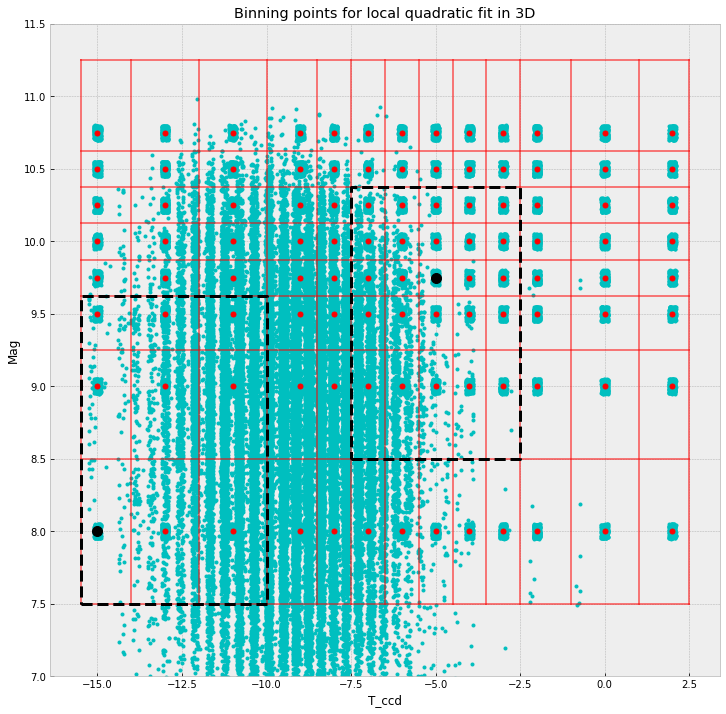

In [15]:
x = flt_asvt['t_ccd'] + np.random.uniform(-0.1, 0.1, len(flt_asvt))
y = flt_asvt['mag_aca'] + np.random.uniform(-0.05, 0.05, len(flt_asvt))
plt.figure(figsize=(12, 12))
plt.plot(x, y, '.', color='c')
plt.ylim(7.0, 11.5);
for mag in mag_bins:
    plt.plot([t_ccd_bins[0], t_ccd_bins[-1]], [mag, mag], color='r', alpha=0.5)
for t_ccd in t_ccd_bins:
    plt.plot([t_ccd, t_ccd], [mag_bins[0], mag_bins[-1]], color='r', alpha=0.5)

x, y = np.meshgrid(t_ccd_vals, mag_vals, indexing='ij')
plt.plot(x, y, 'o', color='r', markersize=5)

# CoPilot note:
# I typed: "plt.plot([-15.5, -10, -10,"" and CoPilot gave the rest with small corrections
plt.plot([-15.5, -10, -10, -15.5, -15.5], [7.5, 7.5, 9.625, 9.625, 7.5], '--', color='k', lw=3)
plt.plot([-7.5, -2.5, -2.5, -7.5, -7.5], [8.5, 8.5, 10.375, 10.375, 8.5], '--', color='k', lw=3)
plt.plot([-15, -5], [8.0, 9.75], 'o', color='k', markersize=10)

plt.xlabel('T_ccd')
plt.ylabel('Mag')
plt.title('Binning points for local quadratic fit in 3D');

In [16]:

def get_samples_successes(dat, mag_bins, t_ccd_bins, halfwidth_bins):
    """
    Aggregate binned number of samples and successes for ASVT data.

    Take the table of acquisition samples and return two 3-d arrays (mag, t_ccd,
    halfwidth):

    - n_samp: number of samples in each bin
    - n_succ: number of successes in each bin
    """
    zeros = np.zeros(
        shape=(len(mag_bins) - 1, len(t_ccd_bins) - 1, len(halfwidth_bins) - 1),
        dtype=int,
    )
    n_samp = zeros.copy()
    n_succ = zeros.copy()

    # Bin halfwidths (narrow since ASVT data are all at the same mag, T_ccd)
    for ii, mag0, mag1 in zip(itertools.count(), mag_bins[:-1], mag_bins[1:]):
        ok0 = (dat["mag_aca"] >= mag0) & (dat["mag_aca"] < mag1)
        for jj, t_ccd0, t_ccd1 in zip(
            itertools.count(), t_ccd_bins[:-1], t_ccd_bins[1:]
        ):
            ok1 = (dat["t_ccd"] >= t_ccd0) & (dat["t_ccd"] < t_ccd1)
            for kk, halfwidth0, halfwidth1 in zip(
                itertools.count(), halfwidth_bins[:-1], halfwidth_bins[1:]
            ):
                ok2 = (dat["halfwidth"] >= halfwidth0) & (dat["halfwidth"] < halfwidth1)
                ok = ok0 & ok1 & ok2
                n_samp[ii, jj, kk] = np.count_nonzero(ok)
                n_succ[ii, jj, kk] = np.count_nonzero(dat["obc_id"][ok])

    return n_samp, n_succ

In [17]:
n_samp, n_succ = get_samples_successes(
    flt_asvt, mag_bins, t_ccd_bins, halfwidth_bins
)

In [18]:
def as_table(arr, fmt=None):
    """Turn one of the summary arrays into a readable table"""
    t = Table()
    t["mag"] = [str(val) for val in mag_vals]
    names = [f"{t_ccd:.1f}" for t_ccd in t_ccd_vals]
    for jj, name in enumerate(names):
        t[name] = arr[:, jj]
        if fmt:
            t[name].info.format = fmt
    return t


In [19]:
as_table(n_samp[:, :, -1])

mag,-15.0,-13.0,-11.0,-9.0,-8.0,-7.0,-6.0,-5.0,-4.0,-3.0,-2.0,0.0,2.0
str5,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
8.0,63,656,2694,4057,2439,1297,347,107,54,38,36,36,36
9.0,67,822,3520,5192,3182,1671,397,135,56,38,36,36,36
9.5,62,410,1630,2431,1264,529,99,56,36,36,36,36,36
9.75,48,222,686,719,285,107,43,39,36,36,36,36,36
10.0,43,127,241,228,117,61,40,36,36,36,36,36,36
10.25,37,52,83,69,48,38,36,36,36,36,36,36,36
10.5,36,46,44,43,37,36,36,36,36,36,36,36,36
10.75,36,37,36,36,36,36,36,36,36,36,36,36,36


In [20]:
def get_successes_slice(
    dat,
    mag0=None,
    mag1=None,
    t_ccd0=None,
    t_ccd1=None,
    halfwidth0=None,
    halfwidth1=None,
):
    ok = np.ones_like(dat["mag_aca"], dtype=bool)
    if mag0 is not None:
        ok &= dat["mag_aca"] >= mag0
    if mag1 is not None:
        ok &= dat["mag_aca"] < mag1
    if t_ccd0 is not None:
        ok &= dat["t_ccd"] >= t_ccd0
    if t_ccd1 is not None:
        ok &= dat["t_ccd"] < t_ccd1
    if halfwidth0 is not None:
        ok &= dat["halfwidth"] >= halfwidth0
    if halfwidth1 is not None:
        ok &= dat["halfwidth"] < halfwidth1
    return dat[ok]


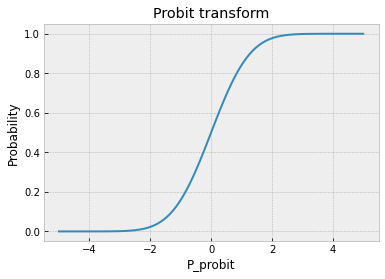

In [57]:
x = np.linspace(-5, 5, 100)
plt.plot(x, stats.norm.cdf(x));
plt.xlabel('P_probit')
plt.ylabel('Probability')
plt.title('Probit transform');

In [21]:
def calc_p_succ(pars, xs, x0s, order, as_probit=False):
    """
    Binomial probability model for N-d data

    Quadratic fit is of the form::

        dx0 = xs[0, :] - x0s[0]
        ...
        dxN-1 = xs[N-1, :] - x0s[N-1]
        p_probit = p0 * dx0 + p1 * dx0**2 + ... + p(2N+1)

    Parameters
    ----------

    pars : array-like
        Model parameters.  The last element is the intercept p(2N+1) and the previous 2N
        are the linear and quadratic coefficients for each of the N dimensions.
    xs : N x M array-like
        M data points in N dimensions
    x0s : N array-like
        Reference point for each dimension
    order : int
        Order of the polynomial fit.  Must be 1 or 2.
    as_probit : bool
        If True then return the probit probability.  If False then return probability.

    Returns
    -------
    prob : M array-like
        Probability of success for each of the M data points
    """
    xs = np.asarray(xs)
    x0s = np.asarray(x0s)

    p_succ_probit = pars[-1] * np.ones(shape=xs.shape[1:])

    for ii in range(len(x0s)):
        dx = (xs[ii, ...] - x0s[ii])
        if order == 1:
            p_succ_probit[...] += pars[ii] * dx
        elif order == 2:
            p_succ_probit[...] += pars[2 * ii] * dx + pars[2 * ii + 1] * dx ** 2
        else:
            raise ValueError(f"order={order} not supported")

    # Possibly transform from probit to linear probability
    out = p_succ_probit if as_probit else stats.norm.cdf(p_succ_probit)

    return out


In [22]:
def calc_binom_stat(succ, p_succ):
    """
    Calculate log-likelihood for a binomial probability distribution.

    Defining p = model, then probability of seeing data == 1 is p and probability of
    seeing data == 0 is (1 - p). Probability of seeing the entire data set is the
    product of the probabilities of each data point.

    Note here that ``data`` is strictly either 0.0 or 1.0, and np.where interprets those
    float values as False or True respectively.

    Parameters
    ----------
    succ : array-like
        Array of successes (True or 1) or failures (False or 0)
    p_succ : array-like (same shape as ``succ``)
        Array of probabilities of success
    """
    bad = (p_succ < 0) | (p_succ > 1)
    if np.any(bad):
        raise ValueError(f"p_succ must be in the range 0 to 1 (got {p_succ[bad]})")
    # Clip to avoid log(0). Large probit values can result in p_succ = 1.0
    p_succ = p_succ.clip(1e-8, 1 - 1e-8)
    
    fit_stat = -np.sum(np.log(np.where(succ, p_succ, 1.0 - p_succ)))

    return fit_stat


In [23]:
def calc_fit_stat(pars, xs, x0s, succ, order):
    """Fitting statistic function for binomial probability model"""
    p_succ = calc_p_succ(pars, xs, x0s, order)
    fit_stat = calc_binom_stat(succ, p_succ)
    return fit_stat

## Example binomial fitting

In [58]:
xs = [np.random.uniform(0, 3, size=1000)]
x0s = [1.5]
pars = [1, 0.25]


In [59]:
p_succ = calc_p_succ(pars, xs, x0s, order=1)

In [60]:
succ = np.random.uniform(size=p_succ.shape) < p_succ

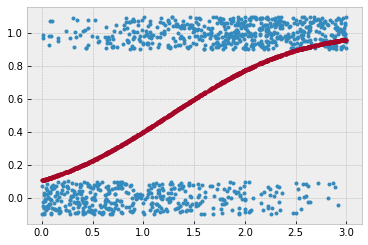

In [71]:
plt.plot(xs[0], succ + np.random.uniform(-0.1, 0.1, size=1000), '.')
plt.plot(xs[0], p_succ, '.');

In [62]:
calc_fit_stat(pars, xs, x0s, succ, order=1)

530.7772796964348

In [63]:
calc_fit_stat([1, 1.0], xs, x0s, succ, order=1)

673.6375056681229

In [64]:
%time optimize.minimize(calc_fit_stat, [0.0, 0.0], args=(xs, x0s, succ, 1))

CPU times: user 8.74 ms, sys: 1.41 ms, total: 10.2 ms
Wall time: 9.11 ms


      fun: 529.9870287098097
 hess_inv: array([[0.00336266, 0.00026231],
       [0.00026231, 0.0019692 ]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 24
      nit: 6
     njev: 8
   status: 0
  success: True
        x: array([0.92976186, 0.22794518])

In [30]:
dok = get_successes_slice(
    flt_asvt,
    mag0=10.125,
    mag1=10.375,
    t_ccd0=-10,
    t_ccd1=-5,
    halfwidth0=55,
    halfwidth1=65,
)

In [31]:
np.mean(dok["obc_id"])


0.7609254498714653

In [32]:
len(dok)

389

In [33]:
%%time
xs = [dok['mag_aca'], dok['t_ccd']]
x0s = [8.0, -14.0]
res = optimize.minimize(calc_fit_stat, [0.0, 0.0, 0.0], args=(xs, x0s, dok['obc_id'], 1))
res

CPU times: user 49.2 ms, sys: 1.8 ms, total: 51 ms
Wall time: 49.8 ms


      fun: 206.4006930133467
 hess_inv: array([[ 1.00966060e-03, -2.96779291e-04, -7.55272152e-04],
       [-2.96779291e-04,  2.70884201e-04,  5.47283481e-05],
       [-7.55272152e-04,  5.47283481e-05,  7.74147940e-04]])
      jac: array([ 1.90734863e-06, -1.90734863e-06,  0.00000000e+00])
  message: 'Optimization terminated successfully.'
     nfev: 201
      nit: 16
     njev: 48
   status: 0
  success: True
        x: array([-2.04286217, -0.20479723,  6.50007686])

In [34]:
from itertools import count

In [35]:
def iterbins(bin_edges, width, include_idxs=False):
    """
    Centers:     0   1   2   3   4   5   6   7   8   9
    Edges:     0   1   2   3   4   5   6   7   8   9   10
    width=1 answers:
       (0, 2), (0, 3), (1, 4) ...
    """
    i_min = 0
    i_max = len(bin_edges) - 1
    for i_center in range(len(bin_edges) - 1):
        i_edge0 = np.clip(i_center - width, i_min, i_max)
        i_edge1 = np.clip(i_center + width + 1, i_min, i_max)
        if include_idxs:
            out = i_center, i_edge0, i_edge1, bin_edges[i_edge0], bin_edges[i_edge1]
        else:
            out = i_center, bin_edges[i_edge0], bin_edges[i_edge1]
        yield out
        

In [36]:
print(mag_bins)
rows = []
for i_center, i_mag0, i_mag1, mag0, mag1 in iterbins(mag_bins, 2, include_idxs=True):
    rows.append((i_center, i_mag0, i_mag1, mag0, mag_vals[i_center], mag1))
t = Table(rows=rows, names=["i_center", "i_mag0", "i_mag1", "mag0", "mag_center", "mag1"])
t

[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


i_center,i_mag0,i_mag1,mag0,mag_center,mag1
int64,int64,int64,float64,float64,float64
0,0,3,7.5,8.0,9.625
1,0,4,7.5,9.0,9.875
2,0,5,7.5,9.5,10.125
3,1,6,8.5,9.75,10.375
4,2,7,9.25,10.0,10.625
5,3,8,9.625,10.25,11.25
6,4,8,9.875,10.5,11.25
7,5,8,10.125,10.75,11.25


In [37]:
n_succ.size

624

In [38]:
print(mag_vals)
print(mag_bins)

[ 8.    9.    9.5   9.75 10.   10.25 10.5  10.75]
[ 7.5    8.5    9.25   9.625  9.875 10.125 10.375 10.625 11.25 ]


In [39]:
def calc_local_quadratic_fit():
    """
    Calculate a local quadratic fit for each bin in the mag, t_ccd, halfwidth

    Quadratic fit is of the form::

        p0 * (mag - mag0) + p1 * (mag - mag0)**2
        + p2 * (t_ccd - t_ccd0) + p3 * (t_ccd - t_ccd0)**2
        + p4 * (halfwidth - halfwidth0) + p5 * (halfwidth - halfwidth0)**2
        + p6

    Returns a 3D array of shape (n_mag, n_t_ccd, n_halfwidth) of P(success).

    (NOTE: CoPilot wrote most of this docstring)
    """
    p_fit = np.zeros(shape=n_succ.shape, dtype=float)
    p_succ = np.zeros_like(p_fit)

    for i_mag, mag0, mag1 in iterbins(mag_bins, width=2):
        mag = mag_vals[i_mag]
        print(f"{mag=} {i_mag=} ({mag0} to {mag1})")

        for i_t_ccd, t_ccd0, t_ccd1 in iterbins(t_ccd_bins, width=2):
            t_ccd = t_ccd_vals[i_t_ccd]

            for i_halfwidth, halfwidth0, halfwidth1 in iterbins(
                halfwidth_bins, width=2
            ):
                halfwidth = halfwidth_vals[i_halfwidth]
                # print(f"{halfwidth=} {i_halfwidth=} ({halfwidth0} to {halfwidth1})")
                dok = get_successes_slice(
                    flt_asvt,
                    mag0=mag0,
                    mag1=mag1,
                    t_ccd0=t_ccd0,
                    t_ccd1=t_ccd1,
                    halfwidth0=halfwidth0,
                    halfwidth1=halfwidth1,
                )
                xs = [dok["mag_aca"], dok["t_ccd"], dok["halfwidth"]]
                x0s = [mag, t_ccd, halfwidth]
                x_init = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                res = optimize.minimize(
                    calc_fit_stat,
                    x_init,
                    args=(xs, x0s, dok["obc_id"], 2),
                )
                p_succ0 = np.count_nonzero(dok["obc_id"]) / len(dok)
                p_fit0 = stats.norm.cdf(res.x[-1])
                p_fit[i_mag, i_t_ccd, i_halfwidth] = p_fit0
                p_succ[i_mag, i_t_ccd, i_halfwidth] = p_succ0

    return p_fit, p_succ


In [40]:
if not Path("p_fit.npz").exists():
    p_fit, p_succ = calc_local_quadratic_fit()
    # CoPilot note:
    # Entered "np.savez" and CoPilot got the rest
    np.savez("p_fit.npz", p_fit=p_fit, p_succ=p_succ)    
else:
    # CoPilot note:
    # Wote "with" and CoPilot wrote the rest
    with np.load("p_fit.npz") as data:
        p_fit = data["p_fit"]
        p_succ = data["p_succ"]

In [41]:
# Print p_fit for mag_aca=10.75. Cols are halfwidth, rows are t_ccd
p_fit[-1].round(3)

array([[0.894, 0.838, 0.827, 0.821, 0.773, 0.79 ],
       [0.801, 0.723, 0.7  , 0.684, 0.642, 0.644],
       [0.685, 0.592, 0.557, 0.539, 0.48 , 0.477],
       [0.571, 0.453, 0.411, 0.388, 0.314, 0.312],
       [0.523, 0.387, 0.333, 0.298, 0.239, 0.224],
       [0.474, 0.3  , 0.241, 0.208, 0.165, 0.143],
       [0.374, 0.19 , 0.143, 0.128, 0.095, 0.084],
       [0.294, 0.122, 0.089, 0.075, 0.052, 0.055],
       [0.216, 0.084, 0.059, 0.045, 0.033, 0.034],
       [0.195, 0.067, 0.047, 0.035, 0.02 , 0.02 ],
       [0.143, 0.053, 0.033, 0.019, 0.008, 0.008],
       [0.084, 0.031, 0.018, 0.009, 0.002, 0.004],
       [0.03 , 0.011, 0.006, 0.002, 0.   , 0.   ]])

In [42]:
p_succ[-1].round(3)


array([[0.831, 0.821, 0.809, 0.784, 0.788, 0.767],
       [0.784, 0.773, 0.758, 0.725, 0.724, 0.704],
       [0.75 , 0.737, 0.72 , 0.678, 0.676, 0.653],
       [0.692, 0.673, 0.649, 0.592, 0.587, 0.556],
       [0.626, 0.6  , 0.571, 0.499, 0.486, 0.454],
       [0.532, 0.502, 0.473, 0.394, 0.383, 0.355],
       [0.419, 0.39 , 0.367, 0.298, 0.296, 0.271],
       [0.318, 0.293, 0.277, 0.22 , 0.225, 0.207],
       [0.247, 0.227, 0.215, 0.168, 0.173, 0.16 ],
       [0.184, 0.171, 0.16 , 0.123, 0.129, 0.12 ],
       [0.14 , 0.128, 0.118, 0.089, 0.09 , 0.08 ],
       [0.12 , 0.109, 0.098, 0.075, 0.074, 0.064],
       [0.101, 0.089, 0.077, 0.057, 0.051, 0.042]])

In [43]:
n_samp[-1]


array([[36, 36, 36, 36, 36, 36],
       [41, 39, 36, 36, 36, 37],
       [47, 41, 41, 38, 37, 36],
       [49, 46, 42, 36, 36, 36],
       [41, 40, 36, 36, 36, 36],
       [37, 36, 37, 38, 37, 36],
       [36, 37, 36, 36, 37, 36],
       [36, 36, 36, 36, 36, 36],
       [36, 36, 36, 36, 36, 36],
       [36, 36, 36, 36, 36, 36],
       [36, 36, 36, 36, 36, 36],
       [36, 36, 36, 36, 36, 36],
       [36, 36, 36, 36, 36, 36]])

In [44]:
n_succ[-1]


array([[31, 26, 30, 30, 27, 25],
       [33, 26, 27, 26, 25, 24],
       [35, 24, 24, 22, 18, 20],
       [33, 17, 20, 12, 10,  9],
       [23, 13, 16, 12,  7, 10],
       [19,  6,  9,  6,  3,  7],
       [16,  9,  5,  3,  4,  3],
       [15,  2,  2,  3,  3,  3],
       [11,  0,  1,  0,  0,  0],
       [11,  1,  2,  1,  1,  2],
       [ 7,  2,  0,  0,  0,  0],
       [ 3,  3,  0,  0,  0,  1],
       [ 1,  0,  0,  0,  0,  0]])

In [45]:
AXIS_LABELS = ["mag", "t_ccd", "halfwidth"]
X_VALS = [mag_vals, t_ccd_vals, halfwidth_vals]


In [46]:
from chandra_aca import star_probs
print(star_probs.DEFAULT_MODEL)

def get_flight_model_probs():
    
    mag_grid, t_ccd_grid, halfwidth_grid = np.meshgrid(
        mag_vals, t_ccd_vals, halfwidth_vals, indexing="ij"
    )
    p_succ_flt = star_probs.acq_success_prob(
        date="2023:001", mag=mag_grid, t_ccd=t_ccd_grid, halfwidth=halfwidth_grid
    )
    return p_succ_flt

grid-floor-2020-02


In [47]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", lineno=288)
    p_succ_flt = get_flight_model_probs()

/Users/aldcroft/miniconda3/envs/ska3/lib/python3.8/site-packages/chandra_aca/star_probs.py:322: UserWarning: 
Model grid-floor-2020-02 computed between t_ccd <= -16.0 <= -1.0, clipping input t_ccd(s) outside that range.
  warnings.warn(


In [48]:
p_succ_flt.shape

(8, 13, 6)

In [49]:
p_fit.shape

(8, 13, 6)

In [50]:

def make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag"):
    idx_x_axis = AXIS_LABELS.index(x_axis)
    idx_x_grid = AXIS_LABELS.index(x_grid)
    idx_y_grid = AXIS_LABELS.index(y_grid)

    n_x_axis = n_samp.shape[idx_x_axis]
    n_x_grid = n_samp.shape[idx_x_grid]
    n_y_grid = n_samp.shape[idx_y_grid]

    size_per_plot = 2.0
    figsize = (size_per_plot * n_x_grid, size_per_plot * n_y_grid)
    from typing import Tuple
    fig, axes = plt.subplots(
        nrows=n_y_grid, ncols=n_x_grid, figsize=figsize, sharex=True, sharey=True
    )
    idxs_point = [None, None, None]

    for i_row in range(n_y_grid):
        idxs_point[idx_y_grid] = i_row

        for i_col in range(n_x_grid):
            idxs_point[idx_x_grid] = i_col
            x = X_VALS[idx_x_axis]
            y = np.empty(shape=(n_x_axis,))
            y_fit = np.empty(shape=(n_x_axis,))
            y_flt = np.empty(shape=(n_x_axis,))
            yerr = np.empty(shape=(2, n_x_axis))

            for i_x in range(n_x_axis):
                idxs_point[idx_x_axis] = i_x
                ijk = tuple(idxs_point)
                k = n_succ[ijk]
                n = n_samp[ijk]
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    sig_low, sig_high = binom_ppf(k, n, [0.16, 0.84])
                p = k / n
                y[i_x] = p
                y_fit[i_x] = p_fit[ijk]
                y_flt[i_x] = p_succ_flt[ijk]
                yerr[0, i_x] = p - sig_low
                yerr[1, i_x] = sig_high - p

            ax = axes[i_row, i_col]
            ax.errorbar(x, y, yerr=yerr, fmt="o-", color="C0")
            ax.plot(x, y_fit, "-", color="C1")
            ax.plot(x, y_flt, "--", color="C2")
            ax.set_ylim(0, 1)
            ax.text(
                0.05,
                0.05,
                f"{x_grid}={X_VALS[idx_x_grid][i_col]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            ax.text(
                0.05,
                0.15,
                f"{y_grid}={X_VALS[idx_y_grid][i_row]}",
                horizontalalignment="left",
                verticalalignment="bottom",
                transform=ax.transAxes,
                fontsize="small",
            )
            # ax.set_title(f"mag={mag_vals[i_mag]:.1f}")

    fig.subplots_adjust(hspace=0, wspace=0)
    fig.suptitle(f"Acq success probability vs {x_axis} "
                 "(blue=ASVT + flight data, red=fit, dashed=flight model)\n")
    fig.tight_layout()


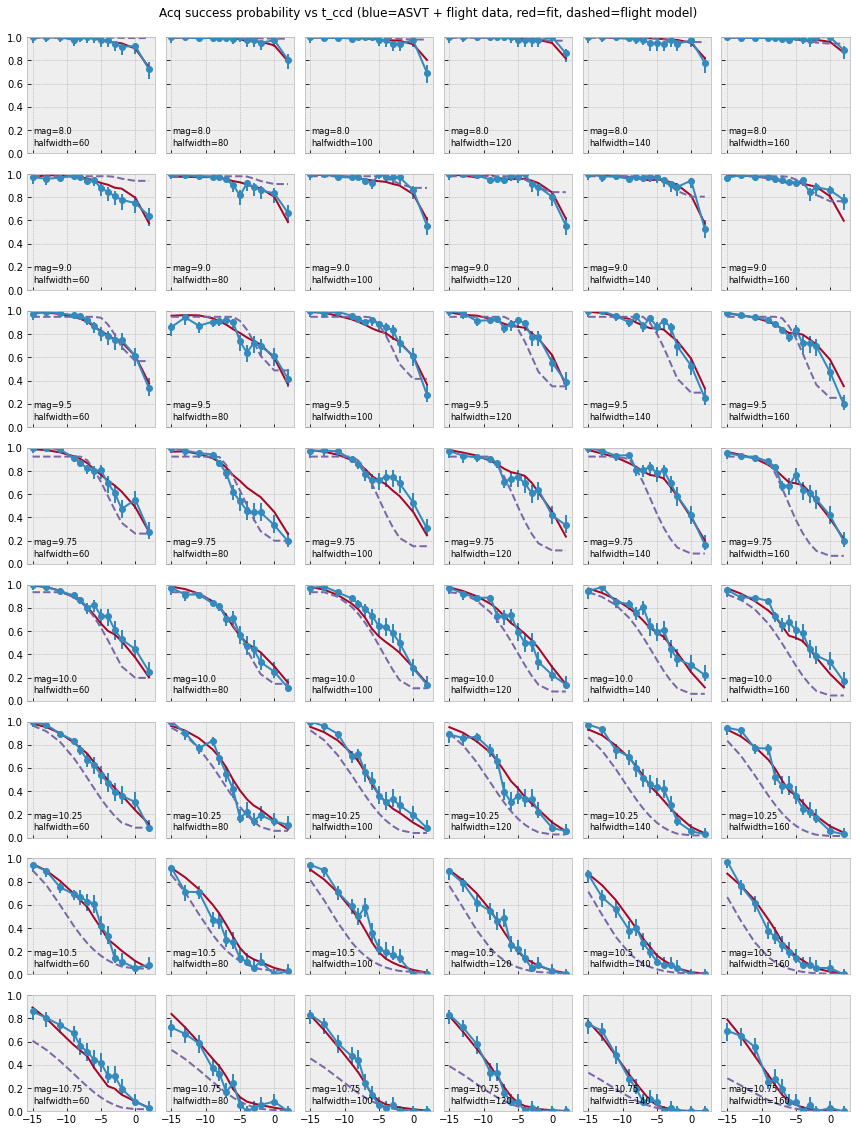

In [51]:
make_plots_grid(x_axis="t_ccd", x_grid="halfwidth", y_grid="mag")

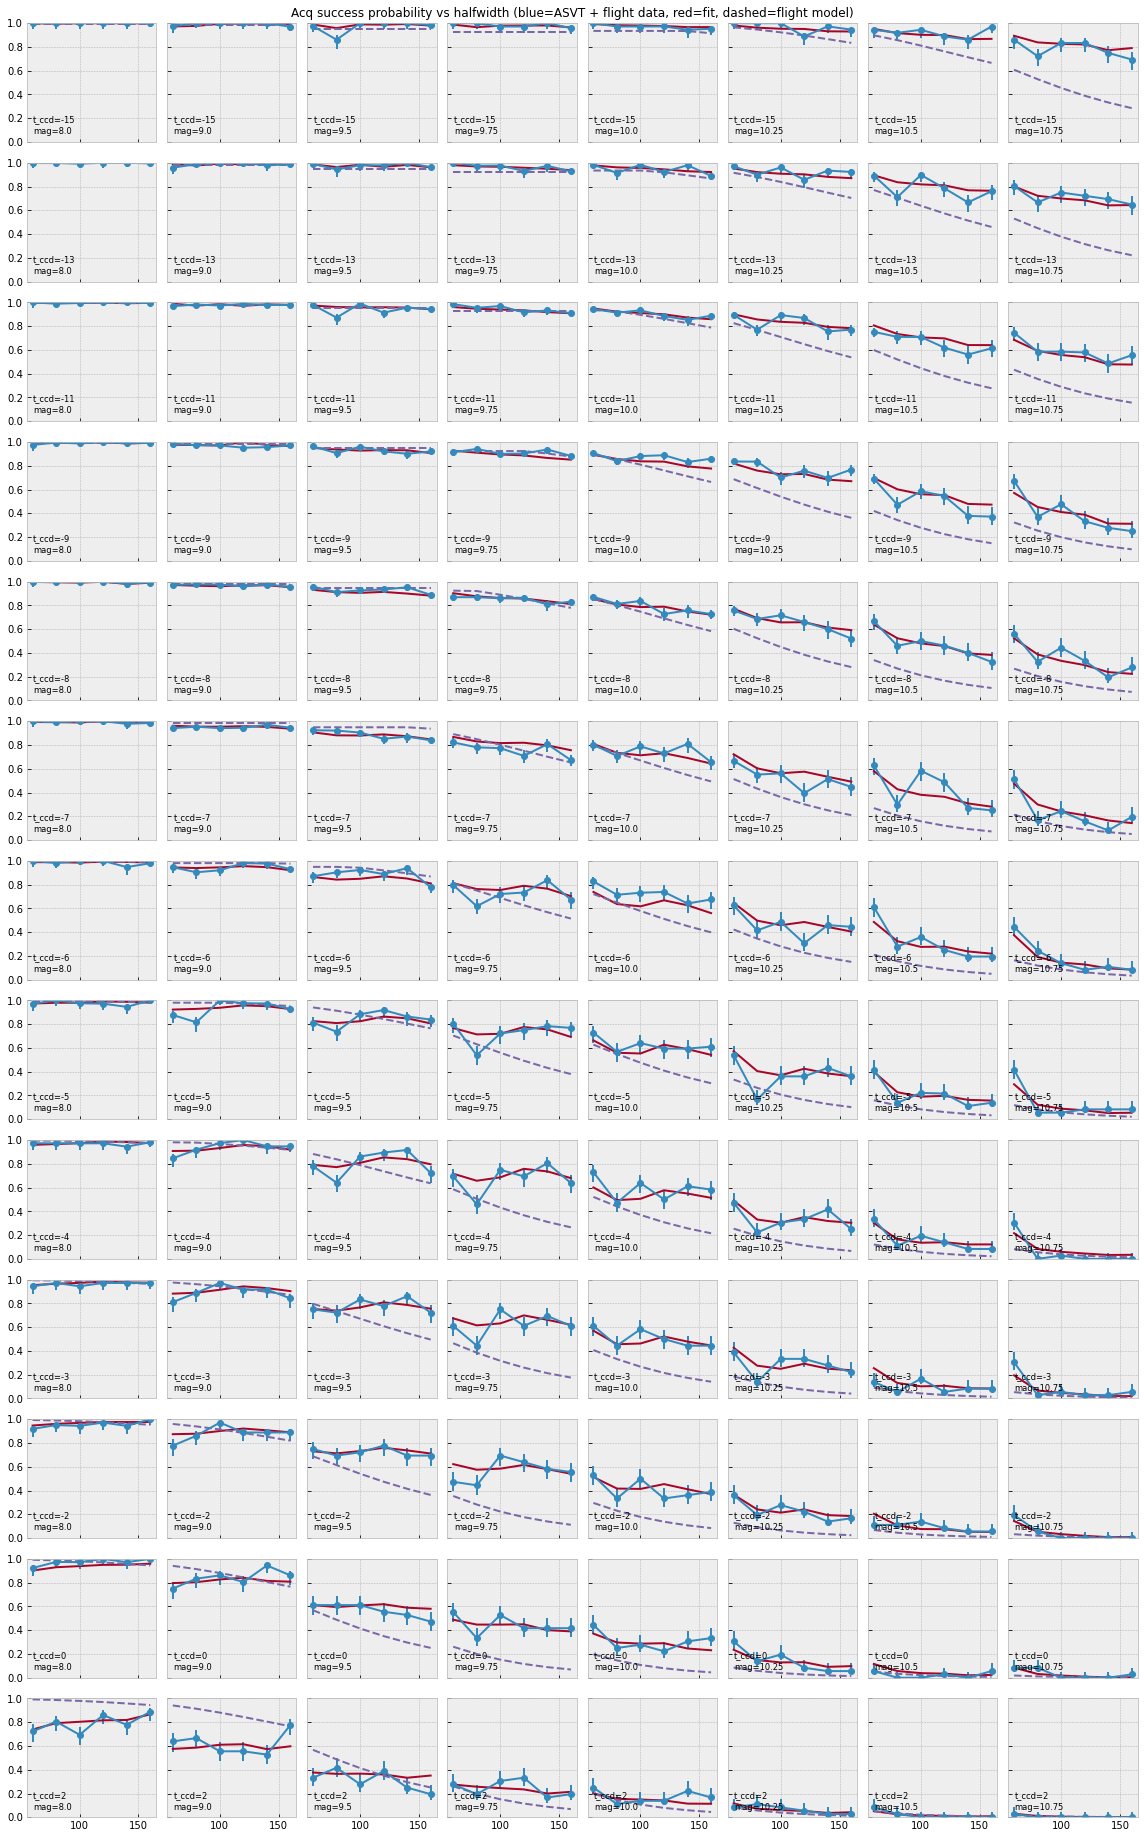

In [52]:
make_plots_grid(x_axis="halfwidth", x_grid="mag", y_grid="t_ccd")

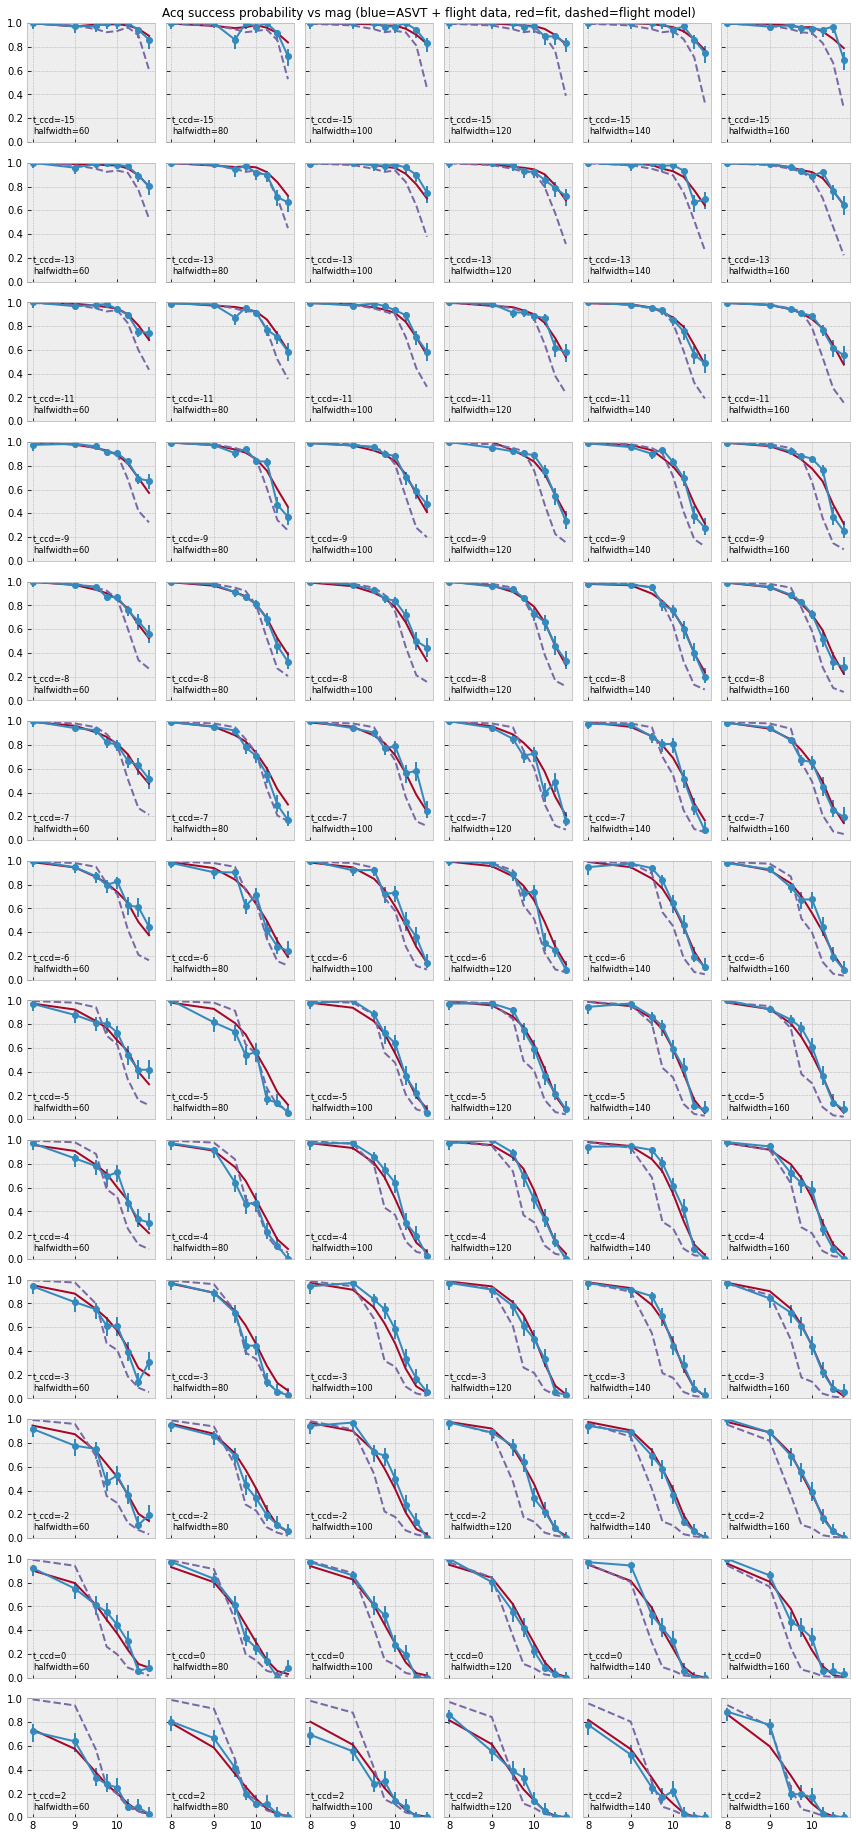

In [53]:
make_plots_grid(x_axis="mag", x_grid="halfwidth", y_grid="t_ccd")